# Deep Sequencing (BIETPS5450)
#### Aug - Dec 2019
__Notebook Description:__ To further investigate the differential gene expression across cell types in various adenocarcinomas, based off of similar analyses done for other cancer and tumor types, such as: [Pan-cancer genome and transcriptome analyses of 1,699 paediatric leukaemias and solid tumours](https://www.nature.com/articles/nature25795) and [Integrating Global Gene Expression and Radiation Survival
Parameters across the 60 Cell Lines of the National Cancer Institute Anticancer Drug Screen](https://cancerres.aacrjournals.org/content/68/2/415)<br>
__Notebook Owner(s):__ Eman Riaz, Beka Stecky, Henry Kim, Tyler Perdue, Rahim Hashim <br>
__\*Dependencies:__ In order to reproduce the environment used in the notebook, activate your virtual environment with the *environment.yml* file contained in the directory (see: [Managing Virtual Environments](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file) for more details)

***
## Notebook Workflow

### 0. Housekeeping, Libraries Import, Path Assignment:
>Details on system configuration, importing the relevant and utilized Python packages, and assigning the path variable appropriately to point to the desired data, dependent on individual's specific directory configuration. 

### 1. Experimental Design
>Additional details on the task design generating imported data.

### 2. Data Import
>Importing all data from downloaded .tsv files. All data was provided by [COSMIC](https://cancer.sanger.ac.uk/cosmic) (Catalog of Somatic Mutations in Cancer).

### 3. Summary Statistics
> Overview analyses of the underlying COSMIC Dataset, and the mutations contained specifically for adenocarcinoma.

### 4. Data Restructuring
>Restructuring the data to perform specific hot-spot and frequency analyses.

### 5. Hot-Spot Gene Selection and Analysis
>Comparative analysis of the different gene mutation frequencies and assigning a likelihood score to the candidates to determine which are most likely to underlie cancerous outcomes.

### 6. Conclusion
>A presentation of the final results and conclusions.

***
## Housekeeping

System Configuration for original notebook execution above:

In [ ]:
print('Current Working Directory:')
!pwd
print('\nSystem Configurations:')
!cat /proc/cpuinfo

Current Working Directory:
/content

System Configurations:
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.000
cache size	: 56320 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4400.00
clflush size	: 64
cac

## Libraries Import

In [1]:
from google.colab import files, drive #only when running on google colab
drive.mount('/content/gdrive') #only when running on google colab
import os
import sys
import pdb
import csv
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from collections import defaultdict # to initalize dictionary types
from IPython.display import display, Image, SVG, Math

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## Path Assignment

Set the path variable *path* appropriately, depending on your directory configuration.

In [2]:
#path = os.getcwd() #for running on Mac
path = '/content/gdrive/My Drive/Columbia/Year II/Fall II/Deep Sequencing/Final Project' #for running on work Linux
all_files = sorted(os.listdir(path))
print('All Files in Directory:')
for index, file in enumerate(all_files):
    print ('\t', str(index) + '. ' + file)

All Files in Directory:
	 0. .ipynb_checkpoints
	 1. Background
	 2. Datasets
	 3. Deep Sequencing.gslides
	 4. DeepSequencing.ipynb
	 5. Final Project - Paper.gdoc
	 6. Final_Images
	 7. Images
	 8. Old_Scripts
	 9. Presentation Outline.gdoc
	 10. adeno_hash.pkl


***
## Experimental Task Design

In this project, we hope to analyze the Cosmic Dataset, specifically looking at genes that are disproportionately mutated at a higher rate compared to the baseline mutation rate in adenocarcinomas. We will also look at the types of mutations, first comparing SNPs vs. other mutation types, and then within SNPs look at transition/transversion mutation types.  

***
## Data Import
Our goal in this project is to be able to compare the same cancer in different tissue types, in order to better understand the different genetic mutation load of these cancers in different tissue types. The first instance of this analyses will be performed on the COSMIC Database.

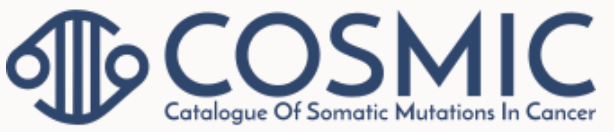

In [ ]:
Image(path+'/Images/CosmicHeader.png', width=450, height=100)

In [3]:
pd.set_option('display.max_columns', 100)
cosmicShape = 35392890
adenoShape = 8878619

# Importing the dataset into a pandas dataframe
def pdInsert():
    '''
    pdInsert loads the Cosmic Dataset (.tsv) and reads it into
    a pandas dataframe, which is then sliced to only select for
    rows that have primary histology 'adenocarcinoma'. These rows
    are then placed into the adenocarcinoma_df to which is used
    throughout the rest of the project, and saved in the directory
    for future use.

    If adenocarcinoma_df is already present in the directory,
    then it is just loaded without opening the larger Cosmic Dataset.
    '''
    datasetsPath = path+'/Datasets/'
    if 'adenocarcinoma_df.csv' not in os.listdir(datasetsPath):
        print('Importing Cosmic Dataset')
        start_time = time.time()
        cosmicPath = datasetsPath+'CosmicGenomeScreensMutantExport.tsv'
        all_fileSize = os.path.getsize(cosmicPath)
        with open(cosmicPath) as tsvfile:
            cosmicDatabase = pd.read_csv(tsvfile, delimiter='\t')
            end_time = time.time()
            print('    Import Run Time:', str(end_time-start_time)[:3], 'sec', '(' + str(all_fileSize/1000000)[:5] + 'MB)')
            cosmicShape = cosmicDatabase.shape[0]
            print('    Size of Entire Dataframe (samples): ', cosmicShape)
            adenocarcinoma_df = cosmicDatabase.loc[cosmicDatabase['Histology subtype 1'] == 'adenocarcinoma']
            adeno_fileSize = os.path.getsize(datasetsPath+'adenocarcinoma_df.csv')
            adenoShape = adenocarcinoma_df.shape[0]
            print('    Size of Adenocarcinoma Dataframe (samples): ', adenoShape)
            start_time = time.time()
            adenocarcinoma_df.to_csv(datasetsPath+'adenocarcinoma_df.csv', sep='\t')
            end_time = time.time()
            print('Saving Adenocarcinoma Dataset')
            print('    adenocarcinoma_df Save Run Time:', str(end_time-start_time)[:3], 'sec', '(' + str(adeno_fileSize/1000000)[:5] + 'MB)')

    else:
        print('Loading adenocarcinoma_df from directory')
        start_time = time.time()
        adenocarcinoma_df = pd.read_csv(datasetsPath+'adenocarcinoma_df.csv', delimiter='\t')
        adeno_fileSize = os.path.getsize(datasetsPath+'adenocarcinoma_df.csv')
        end_time = time.time()
        adenoShape = adenocarcinoma_df.shape[0]
        print('    Size of Adenocarcinoma Dataframe (samples): ', adenoShape)
        print('    adenocarcinoma_df Import Run Time:', str(end_time-start_time)[:3], 'sec', '(' + str(adeno_fileSize/1000000)[:5] + 'MB)')
    return adenocarcinoma_df
    
adenocarcinoma_df = pdInsert()

Loading adenocarcinoma_df from directory
    Size of Adenocarcinoma Dataframe (samples):  8878619
    adenocarcinoma_df Import Run Time: 54. sec (2750.MB)


In [ ]:
pd.set_option('display.max_columns', 100)

# First 20 rows of the entire Cosmic Database
adenocarcinoma_df.head(20)

,Unnamed: 0,Gene name,Accession Number,Gene CDS length,HGNC ID,Sample name,ID_sample,ID_tumour,Primary site,Site subtype 1,Site subtype 2,Site subtype 3,Primary histology,Histology subtype 1,Histology subtype 2,Histology subtype 3,Genome-wide screen,MUTATION_ID,GENOMIC_MUTATION_ID,LEGACY_MUTATION_ID,Mutation CDS,Mutation AA,Mutation Description,Mutation zygosity,LOH,GRCh,Mutation genome position,Mutation strand,SNP,FATHMM prediction,FATHMM score,Mutation somatic status,Pubmed_PMID,ID_STUDY,Sample Type,Tumour origin,Age
0,4,PORCN_ENST00000359882,ENST00000359882.8,1877,17652.0,T213,2658379,2518538,large_intestine,NS,NS,NS,carcinoma,adenocarcinoma,NS,NS,y,94463450,COSV52141488,COSN26989926,c.*50C>T,p.?,Unknown,NaN,NaN,38.0,23:48520526-48520526,+,n,PATHOGENIC,0.84330,Confirmed somatic variant,27149842.0,NaN,NS,NS,61.25
1,8,AP5Z1,ENST00000348624.4,2901,22197.0,HUB-02-B2-087,2607141,2466853,large_intestine,NS,NS,NS,carcinoma,adenocarcinoma,NS,NS,y,93227367,COSV62241638,COSM6038994,c.1919C>T,p.A640V,Substitution - Missense,NaN,NaN,38.0,7:4790572-4790572,+,n,PATHOGENIC,0.80912,Confirmed somatic variant,NaN,670.0,organoid culture,NS,NaN
2,10,OR5A2_ENST00000641361,ENST00000641361.1,6655,15249.0,LP6005409-DNA_B04,2549501,2410956,oesophagus,NS,NS,NS,carcinoma,adenocarcinoma,NS,NS,y,146049795,COSV57391387,COSN23641447,c.-491A>T,p.?,Unknown,NaN,NaN,38.0,11:59426233-59426233,+,n,NEUTRAL,0.09144,Confirmed somatic variant,NaN,535.0,NS,primary,NaN
3,13,THEMIS,ENST00000630369.2,2786,21569.0,LP6005690-DNA_D01,2263414,2130398,oesophagus,NS,NS,NS,carcinoma,adenocarcinoma,NS,NS,y,146773237,COSV64070700,COSN17424375,c.250+1179G>C,p.?,Unknown,NaN,NaN,38.0,6:127853851-127853851,+,n,NEUTRAL,0.03103,Confirmed somatic variant,NaN,535.0,NS,primary,NaN
4,15,THEMIS,ENST00000630369.2,2786,21569.0,587376,1766805,1671125,large_intestine,colon,NS,NS,carcinoma,adenocarcinoma,NS,NS,y,146779744,COSV64072647,COSM1229161,c.19G>T,p.E7*,Substitution - Nonsense,NaN,NaN,38.0,6:127900914-127900914,+,n,NaN,0.64902,Variant of unknown origin,22895193.0,NaN,surgery fresh/frozen,primary,NaN
5,17,THEMIS,ENST00000630369.2,2786,21569.0,0119_CRUK_PC_0119_T1_DNA,2457589,2320426,prostate,NS,NS,NS,carcinoma,adenocarcinoma,NS,NS,y,146784309,COSV64074793,COSN19519824,c.1875+5042C>T,p.?,Unknown,NaN,NaN,38.0,6:127802174-127802174,+,n,NEUTRAL,0.00456,Confirmed somatic variant,NaN,538.0,NS,primary,57.00
6,19,THEMIS,ENST00000630369.2,2786,21569.0,LP6005409-DNA_E02,2263377,2130361,oesophagus,NS,NS,NS,carcinoma,adenocarcinoma,NS,NS,y,146781728,COSV64073699,COSN15104754,c.92-16601C>A,p.?,Unknown,NaN,NaN,38.0,6:127871789-127871789,+,n,NEUTRAL,0.00738,Confirmed somatic variant,NaN,535.0,NS,primary,NaN
7,22,IRF6_ENST00000542854,ENST00000542854.5,4256,6121.0,CPCG0123-F1,2340851,2205834,prostate,NS,NS,NS,carcinoma,adenocarcinoma,NS,NS,y,131394378,COSV65418639,COSN27928355,c.-111-82T>G,p.?,Unknown,NaN,NaN,38.0,1:209796634-209796634,+,n,NEUTRAL,0.00474,Confirmed somatic variant,NaN,537.0,NS,primary,NaN
8,27,NLRP12_ENST00000391772,ENST00000391772.1,3205,22938.0,TCGA-BR-A4QL-01,2197931,2066209,stomach,NS,NS,NS,carcinoma,adenocarcinoma,NS,NS,y,99777853,COSV60743594,COSM4081077,c.2592-4129G>A,p.?,Unknown,NaN,NaN,38.0,19:53798265-53798265,+,n,NEUTRAL,0.00145,Confirmed somatic variant,NaN,541.0,NS,NS,75.00
9,29,NLRP12_ENST00000391772,ENST00000391772.1,3205,22938.0,T3064,2296168,2161771,large_intestine,colon,transverse,NS,carcinoma,adenocarcinoma,NS,NS,y,99783014,COSV60748411,COSM4707248,c.1952C>T,p.S651L,Substitution - Missense,NaN,NaN,38.0,19:53809707-53809707,+,n,NEUTRAL,0.09601,Confirmed somatic variant,25344691.0,NaN,NS,NS,75.50


***

## Summary Statistics on Gene Mutation Rates

As a first pass through the dataset,  we want to look at:

1.   The total number of mutations captured in the dataset for adenocarcinoma *(Figure 1)*
2.   The total number of mutations captured, by tissue type, specifically for adenocarcinoma *(Figure 2)*
3.   The top 100 genes that have the highest number of mutations *(Figure 3)*
4.   The relataionship between gene length and total number of mutations *(Figure 4)*
5.   The total number of different types of mutations *(Figure 5)*

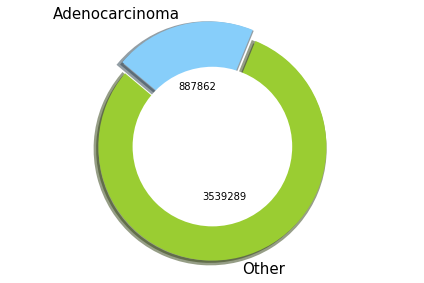

In [ ]:
# Convert values from percentages (default for plt.pie) to absolute values
def absolute_value(val):
    a  = np.round(val/1000.*sizes.sum(), 0)
    return int(a)

f, ax = plt.subplots()

cancers = 'Other', 'Adenocarcinoma'
sizes = np.array([cosmicShape, adenoShape])
colors = ['yellowgreen', 'lightskyblue']
explode = (0, 0.1)  # explode 2nd and 3rd slice

centre_circle = plt.Circle((0,0),0.70,fc='white')
f = plt.gcf()
f.gca().add_artist(centre_circle)

# Plot
wedges, labels, autopct = plt.pie(sizes, explode=explode, labels=cancers, colors=colors,
        autopct=absolute_value, shadow=True, startangle=140,
        labeldistance = 1.1, pctdistance = .45,
        wedgeprops = {'linewidth': 5}, 
        textprops={'fontsize': 10})

plt.setp(labels, fontsize=15)
plt.tight_layout()
plt.axis('equal')
plt.savefig(path+'/Images/dataset_size.png', dpi=300)

**Figure 1:** The total number of mutations captured for adenocarcinoma as the primary histology.

primary_site_plotter Run Time: 3.4 sec


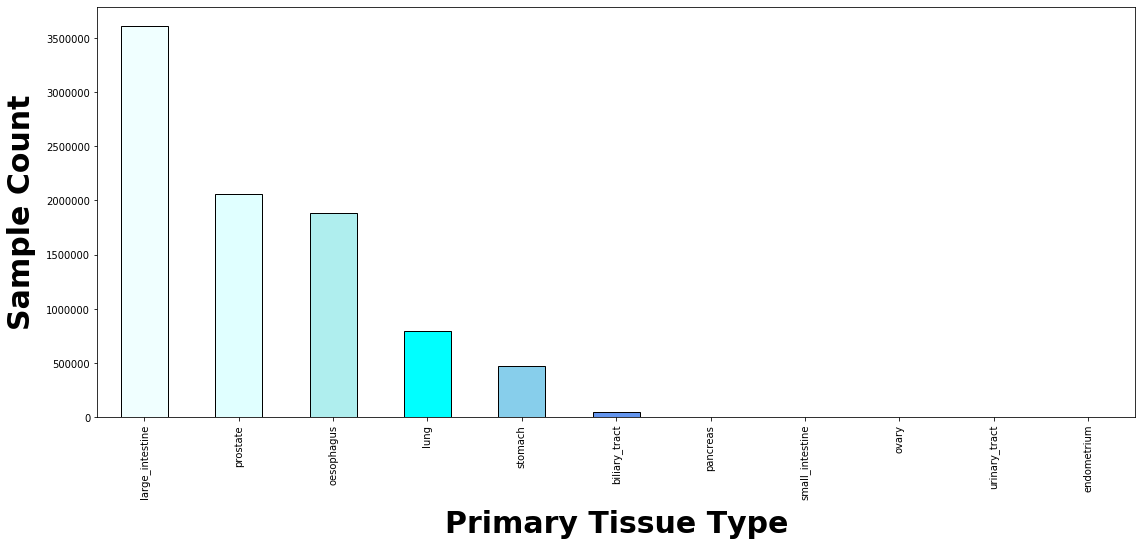

In [ ]:
#Plot the different tissue types for each type of cancer
color_list = ['azure', 'lightcyan', 'paleturquoise', 'cyan',
             'skyblue', 'cornflowerblue', 'deepskyblue', 'darkcyan',
              'steelblue', 'blue', 'midnightblue', 'darkblue']

def primary_site_plotter():
    '''
    primary_site_plotter plots the different primary tissue types
    for adenocarcinomas
    '''
    start_time = time.time()
    f, ax = plt.subplots(1)
    value_counts = adenocarcinoma_df['Primary site'].value_counts()
    ax = value_counts.plot(kind='bar', edgecolor='black', color=color_list)
    ax.set_xlabel('Primary Tissue Type', fontweight='bold', labelpad=10, fontsize=30)
    ax.set_ylabel('Sample Count', fontweight='bold', labelpad=10, fontsize=30)
    plt.tight_layout(pad=0.05, w_pad=4, h_pad=1.0)
    #plt.title(cancer_type, fontsize=24)
    f.set_size_inches(18.5, 10.5, forward=True)
    plt.savefig(path+'/Images/tissue_types.png', dpi=300)
    end_time = time.time()
    print('primary_site_plotter Run Time:', str(end_time-start_time)[:3], 'sec')

primary_site_plotter()

**Figure 2:** The total number of mutations for adenocarcinoma samples by primary tissue type.

gene_plotter Run Time: 5.6 sec


KeyboardInterrupt: ignored

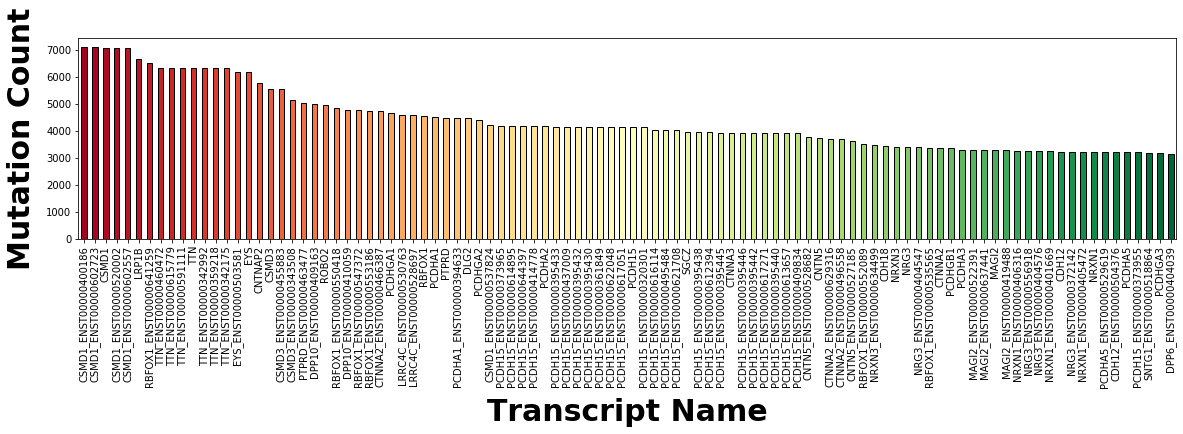

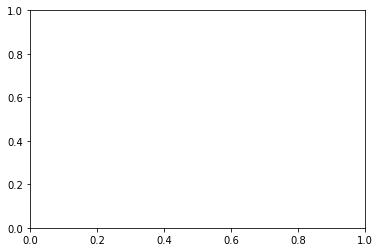

In [ ]:
def mutation_count_plotter_transcripts(plot_size):
    '''
    mutation_count_plotter plots:
    1) the top 100 genes that have the highest number of mutations
    2) the relationship between gene length and mutation count
    3) the total number of mutations by type
    '''

    # gene plotter
    start_time = time.time()
    f, ax = plt.subplots(1)
    genes_mutation_count = adenocarcinoma_df['Gene name'].value_counts()
    colors = mpl.cm.RdYlGn(np.linspace(0,1,plot_size))
    ax = genes_mutation_count.iloc[0:plot_size].plot(kind='bar', edgecolor='black', color=colors) #only the first 100 genes
    ax.set_xlabel('Transcript Name', fontweight='bold', labelpad=10, fontsize=30)
    ax.set_ylabel('Mutation Count', fontweight='bold', labelpad=10, fontsize=30)
    plt.tight_layout(pad=0.05, w_pad=4, h_pad=1.0)
    f.set_size_inches(18.5, 10.5, forward=True)
    plt.savefig(path+'/Images/transcripts.png', dpi=300)
    end_time = time.time()
    print('gene_plotter Run Time:', str(end_time-start_time)[:3], 'sec')

    # gene length x mutation count plotter
    start_time = time.time()
    f, ax = plt.subplots(1)
    gene_list = genes_mutation_count.index.tolist()
    mutation_count_list = list(genes_mutation_count)
    gene_length_list = []
    for gene in tqdm(gene_list):
      gene_length_list.append(adenocarcinoma_df[adenocarcinoma_df['Gene name'] == gene].iloc[0]['Gene CDS length'])
    colors = mpl.cm.RdYlGn(np.linspace(0,1,len(gene_list)))
    ax.set_xlabel('Transcript Length', fontweight='bold', labelpad=10, fontsize=30)
    ax.set_ylabel('Mutation Count', fontweight='bold', labelpad=10, fontsize=30)
    plt.scatter(gene_length_list, mutation_count_list, color=colors)
    plt.tight_layout(pad=0.05, w_pad=4, h_pad=1.0)
    f.set_size_inches(18.5, 10.5, forward=True)
    plt.savefig(path+'/Images/gene_length_transcripts.png', dpi=300)
    end_time = time.time()
    print('gene_length_plotter Run Time:', str(end_time-start_time), 'sec')
    
    return genes_mutation_count

genes_mutation_count = mutation_count_plotter_transcripts(plot_size=100)

**Figure 3:** The top 100 genes that have the highest number of mutations. <br>
**Figure 4:** The gene length vs. mutation count for all genes caaptured in the dataset. <br>
**Figure 5:** The mutation count for each mutation type.

As we can see, there are multiple alternative transcripts captured for the various genes, not reflecting the true mutation rates in the the above dataframe structures and analyses. Therefore, we will look to convert the dataframe into a python dictionary that orders the data by **gene** rather than by **mutation**.

***
## Data Restructuring

Converting the pandas dataframe to a python dictionary with primary key as gene. Importantly, all the alternative transcripts will be combined. 


In [4]:
def adeno_hash_generator():
    '''
    adeno_hash_generator takes the adenocarinoma_df 
    and converts it into a dictionary, in which the
    primary key is the gene name (combining transcripts)
    and the values are each of the important fields for
    further analysis.
    '''
    adeno_hash = {}
    if 'adeno_hash.pkl' not in os.listdir(path+'/Datasets/'):
        print('Generating adeno_hash')
        for index, row in tqdm(adenocarcinoma_df.iterrows()):
            gene = row['Gene name'].split('_')[0]
            gene_position = row['Mutation genome position']
            transcript_length = row['Gene CDS length']
            primary_site = row['Primary site']
            cds = row['Mutation CDS']
            FATHMM_prediction = row['FATHMM prediction']
            FATHMM_score = row['FATHMM score']
            mutation_description = row['Mutation Description']
            age = row['Age']
            if gene in adeno_hash.keys():
                adeno_hash[gene]['gene_position'].append(gene_position)
                adeno_hash[gene]['primary_site'].append(primary_site)
                adeno_hash[gene]['transcript_length'].append(int(transcript_length))
                adeno_hash[gene]['cds'].append(cds)
                adeno_hash[gene]['FATHMM_prediction'].append(FATHMM_prediction)
                adeno_hash[gene]['FATHMM_score'].append(float(FATHMM_score))
                adeno_hash[gene]['Mutation Description'].append(mutation_description)
                adeno_hash[gene]['Age'].append(age)
            else:
                adeno_hash[gene] = {}
                adeno_hash[gene]['gene_position'] = [gene_position]
                adeno_hash[gene]['primary_site'] = [primary_site]
                adeno_hash[gene]['transcript_length'] = [int(transcript_length)]
                adeno_hash[gene]['cds'] = [cds]
                adeno_hash[gene]['FATHMM_prediction'] = [FATHMM_prediction]
                adeno_hash[gene]['FATHMM_score'] = [float(FATHMM_score)]
                adeno_hash[gene]['Mutation Description'] = [mutation_description]
                adeno_hash[gene]['Age'] = [age]
        for gene in adeno_hash.keys():
            adeno_hash[gene]['gene_length'] = np.average(adeno_hash[gene]['transcript_length'])
            adeno_hash[gene]['mutation_count'] = len(adeno_hash[gene]['primary_site'])
        with open(path+'/Datasets/adeno_hash.pkl', 'wb') as f:
            # Save the dictionary through pickle
            pickle.dump(adeno_hash, f, protocol=4)
            print('adeno_hash saved')
    else:
        print('Importing adeno_hash.pkl')
        with open(path+'/Datasets/adeno_hash.pkl', 'rb') as f:
            # Load the dictionary through pickle
            adeno_hash = pickle.load(f)
        print('adeno_hash imported')
    return adeno_hash

adeno_hash = adeno_hash_generator()

Importing adeno_hash.pkl
adeno_hash imported



gene_plotter Run Time: 2.7 sec
gene_length_plotter Run Time: 4.180963754653931 sec


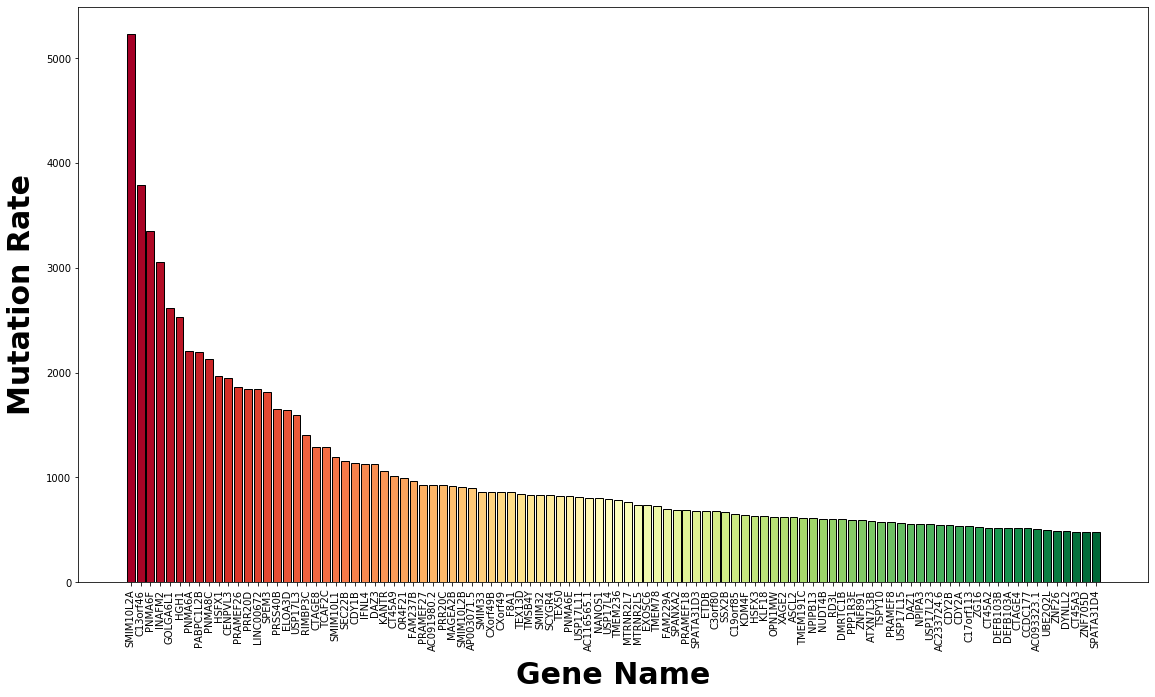

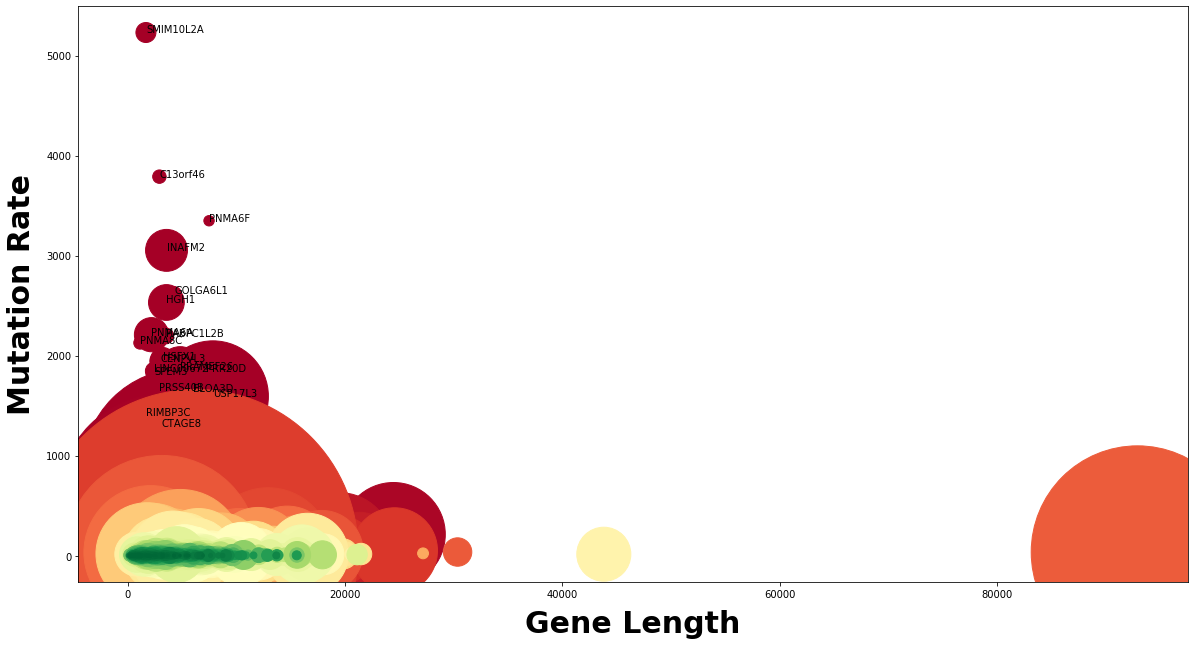

In [ ]:
def sort_list(list1, list2): 
    '''
    sort_list sorts two lists by the value in list1
    '''
    list1, list2 = (list(t) for t in zip(*sorted(zip(list1, list2))))
    return list1, list2

def mutation_count_plotter_genes(adeno_hash):    
    '''
    mutation_count_plotter_genes takes adeno_hash and plots 
    the top 100 genes (not transcripts) with the higest 
    mutation rate (i.e. gene length / mutation count).
    '''
    gene_length = []; mutation_count = []; mutation_rate = []
    for index, gene in enumerate(tqdm(adeno_hash.keys())):
        gene_length.append(adeno_hash[gene]['gene_length'])
        mutation_count.append(adeno_hash[gene]['mutation_count'])
        mutation_rate.append(adeno_hash[gene]['gene_length']/adeno_hash[gene]['mutation_count'])
        
    # Sorting the lists by mutation count
    mutation_rate, gene_list = sort_list(mutation_rate, list(adeno_hash.keys()))
    gene_list.reverse(); mutation_rate.reverse()
    
    # gene mutation rate plotter
    start_time = time.time()
    f, ax = plt.subplots(1)
    colors = mpl.cm.RdYlGn(np.linspace(0,1,100))
    ax.bar(gene_list[:100], mutation_rate[:100], edgecolor='black', color=colors) #only the first 100 genes
    ax.set_xlabel('Gene Name', fontweight='bold', labelpad=10, fontsize=30)
    ax.set_ylabel('Mutation Rate', fontweight='bold', labelpad=10, fontsize=30)
    plt.tight_layout(pad=0.05, w_pad=4, h_pad=1.0)
    plt.xticks(rotation=90)
    f.set_size_inches(18.5, 10.5, forward=True)
    plt.savefig(path+'/Images/genes_mutation_rate.png', dpi=300)
    end_time = time.time()
    print('gene_plotter Run Time:', str(end_time-start_time)[:3], 'sec')

    # gene length x mutation rate plotter
    start_time = time.time()
    f, ax = plt.subplots(1)
    ax.set_xlabel('Gene Length', fontweight='bold', labelpad=10, fontsize=30)
    ax.set_ylabel('Mutation Rate', fontweight='bold', labelpad=10, fontsize=30)
    colors = mpl.cm.RdYlGn(np.linspace(0,1,len(gene_length)))
    sc = plt.scatter(gene_length, mutation_rate, s=mutation_count, color=colors)
    plt.tight_layout(pad=0.05, w_pad=4, h_pad=1.0)
    f.set_size_inches(18.5, 10.5, forward=True)
    handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
    for i, txt in enumerate(gene_list[:20]):
        ax.annotate(txt, (gene_length[i], mutation_rate[i]))
    #plt.legend(*sc.legend_elements("sizes", num=20))
    plt.savefig(path+'/Images/gene_length_genes.png', dpi=300)
    end_time = time.time()
    print('gene_length_plotter Run Time:', str(end_time-start_time), 'sec')

mutation_count_plotter_genes(adeno_hash)

**Figure 6:** Top 100 genes, sorted by mutation rate (gene length / mutation count).<br>
**Figure 7:** Mutation rate x gene length. Size of point is proportional to the mutation count.

### SMIM10L2A
This gene encodes a highly conserved small protein that contains a conserved motif (DUF4560) and may function as an integral membrane protein. This transcript was also shown to associate with enhancer chromatin and therefore may also function as an RNA to regulate enhancers ([SMIM10L2A Gene Card](https://https://www.ncbi.nlm.nih.gov/gene?Db=gene&Cmd=DetailsSearch&Term=399668)).

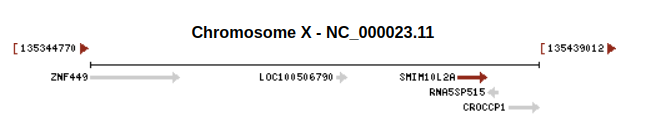

In [ ]:
Image(path+'/Images/SMIM10L2A_Gene_Card.png', width=450, height=100)

### C13orf46
Uncharacterized protein.


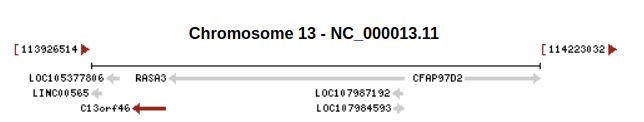

In [ ]:
Image(path+'/Images/C13orf46_Gene_card.png', width=450, height=100)

### PNMA6F
Uncharacterized protein.

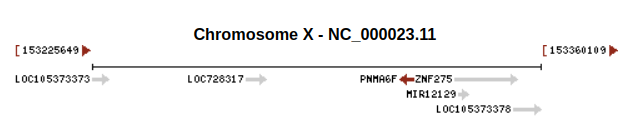

In [ ]:
Image(path+'/Images/PNMA6F_Gene_card.png', width=450, height=100)

# Beka

What I'm interested in is this question: What are the specific point mutations most commonly found in cancers, and what are their molecular nature? This gives us the opportunity to talk about a hypothesis mentioned in class - that transition mutations are 10x more common than transversion mutations (Samocha 2014). I want to spend a little bit of time during our presentation talking about transitions and transversion, why the former is more common than the later, and what kinds of residue mutations we can find from transition mutations. We can also talk about silent mutations (wobble, etc.) as well and what they could potentially do, translationally-speaking. 

To do for Rahim: Look for point mutations in cancer types, and identify the nature thereof (e.g. C>A, C>G, T>C, etc.).

To do for Beka: Recreate Fig 1 from Alexandrov 2013 after Rahim crunches the data.

"Somatic mutations are conventionally grouped into four classes;
base substitutions, small indels, rearrangements, and copy
number changes. These can be further subclassified into biologically meaningful subgroups. For example, base substitutions
are often classified into six subtypes; C:G > A:T, C:G > G:C,
C:G > T:A, T:A > A:T, T:A > C:G, and T:A > G:C. Classification
of substitutions may be further refined by including the sequence
context of each mutated base, either 50 or 30 or both. For
example, a C:G > T:A mutation can be characterized as TpCpG >
TpTpG (mutated base underlined and presented as the pyrimidine partner of the mutated base pair) generating 96 possible mutation types (6 types of substitution * 4 types of 50 base * 4 types of 30 base). This can be further elaborated by considering the transcriptional strand on which a substitution resides. In principle, similar approaches could be taken for the other major classes of mutation (i.e., indels, rearrangements, and copy number changes) and all classes and subclasses of mutation could be incorporated into one analysis."

Pseudo-code based on the description above: 1) ID all point mutations (as compared to the non-cancer genome [TCGA]). 2) ID the adjacent bases to the point mutation's locus; the identity of this triplet (original base identity > mutant) is called the mutational signature. 3) ID the most common mutational signature in each cancer subtype and see if they're similar. 

Relevant columns: Mutation CDS (the molecular nature of the mutation itself), Mutation Description (incomplete in this dataset, but we can easily figure it out by looking at the Mutation CDS and the Mutation Genome Position), and Mutation Genome Position (where it is).

In [ ]:
from operator import itemgetter

def tissue_hash_init(select_hash, tissue):
    '''
    tissue_hash_init initializes the dictionary
    point_mutation_type_hash_tissue by setting 
    the counter to 0 for each mutation type 
    for each tissue key.
    '''
    select_hash[tissue] = {}
    bins = ['C>T | G>A', 'A>G | T>C', 'G>C | C>G', 'G>T | C>A', 'T>A | A>T', 'T>G | A>C']
    for bin_type in bins:
        select_hash[tissue][bin_type] = 0

def tissue_hash_init_fathmm(select_hash, tissue):
    '''
    tissue_hash_init initializes the dictionary
    point_mutation_type_hash_tissue by setting 
    the counter to 0 for each mutation type 
    for each tissue key.
    '''
    select_hash[tissue] = {}
    bins = ['C>T | G>A', 'A>G | T>C', 'G>C | C>G', 'G>T | C>A', 'T>A | A>T', 'T>G | A>C']
    for bin_type in bins:
        select_hash[tissue][bin_type] = []

def equivalent_mutation(select_hash, mutation, gene_length):
    '''
    equivalent_mutation bins mutation types by transitions/transversions.
        1) C>T = G>A, (transition)  
        2) A>G = T>C, (transition) 
        3) G>C = C>G, (transversion) 
        4) G>T = C>A, (transversion) 
        5) T>A = A>T, (transversion) 
        6) T>G = A>C. (transversion) 
    into the point_mutation_type_hash_tissue dictionary
    '''
    if mutation == 'C>T' or mutation == 'G>A':
        select_hash['C>T | G>A'] += 1/gene_length
    elif mutation == 'A>G' or mutation == 'T>C':
        select_hash['A>G | T>C'] += 1/gene_length
    elif mutation == 'G>C' or mutation == 'C>G':
        select_hash['G>C | C>G'] += 1/gene_length
    elif mutation == 'G>T' or mutation == 'C>A':
        select_hash['G>T | C>A'] += 1/gene_length
    elif mutation == 'T>A' or mutation == 'A>T':
        select_hash['T>A | A>T'] += 1/gene_length
    elif mutation == 'T>G' or mutation == 'A>C':
        select_hash['T>G | A>C'] += 1/gene_length
    return(select_hash)


def equivalent_mutation_fathmm(select_hash, mutation, gene, fathmm):
    '''
    equivalent_mutation bins mutation types by transitions/transversions.
        1) C>T = G>A, (transition)  
        2) A>G = T>C, (transition) 
        3) G>C = C>G, (transversion) 
        4) G>T = C>A, (transversion) 
        5) T>A = A>T, (transversion) 
        6) T>G = A>C. (transversion) 
    into the point_mutation_type_hash_tissue dictionary
    '''
    if mutation == 'C>T' or mutation == 'G>A' and fathmm > 0.7:
        select_hash['C>T | G>A'].append(gene)
    elif mutation == 'A>G' or mutation == 'T>C':
        select_hash['A>G | T>C'].append(gene)
    elif mutation == 'G>C' or mutation == 'C>G':
        select_hash['G>C | C>G'].append(gene)
    elif mutation == 'G>T' or mutation == 'C>A':
        select_hash['G>T | C>A'].append(gene)
    elif mutation == 'T>A' or mutation == 'A>T':
        select_hash['T>A | A>T'].append(gene)
    elif mutation == 'T>G' or mutation == 'A>C':
        select_hash['T>G | A>C'].append(gene)
    return(select_hash)


def mutation_spread():
    '''
    mutation_spread analyzes the different types of mutations
    represented in the dataset.
    '''
    point_mutation_type_hash = defaultdict(int)
    other_mutation_type_hash = defaultdict(float)
    point_mutation_type_hash_tissue = defaultdict(lambda: defaultdict(int))
    point_mutation_type_hash_tissue_fathmm = defaultdict(lambda: defaultdict(int))
    #other_mutation_type_hash_tissue = defaultdict(defaultdict(float))
    for gi, gene in enumerate(adeno_hash.keys()):
        for mi, mutation in enumerate(adeno_hash[gene]['cds']):
            tissue = adeno_hash[gene]['primary_site'][mi]
            if '<' in mutation or '>' in mutation:
                point_mutation_type_hash = \
                    equivalent_mutation(point_mutation_type_hash, mutation[-3:], len(adeno_hash[gene]['cds']))
                if tissue not in point_mutation_type_hash_tissue.keys():
                    tissue_hash_init(point_mutation_type_hash_tissue, tissue)
                    tissue_hash_init_fathmm(point_mutation_type_hash_tissue_fathmm, tissue)
                point_mutation_type_hash_tissue[tissue] = \
                    equivalent_mutation(point_mutation_type_hash_tissue[tissue], mutation[-3:], len(adeno_hash[gene]['cds']))
                point_mutation_type_hash_tissue_fathmm[tissue] = \
                    equivalent_mutation_fathmm(point_mutation_type_hash_tissue_fathmm[tissue], mutation[-3:], gene, adeno_hash[gene]['FATHMM_score'][mi])
            else:
                if 'del' in mutation:
                   other_mutation_type_hash['del'] += 1/(len(adeno_hash[gene]['cds']))
                elif 'dup' in mutation:
                   other_mutation_type_hash['dup'] += 1/(len(adeno_hash[gene]['cds']))
                elif 'ins' in mutation:
                   other_mutation_type_hash['ins'] += 1/(len(adeno_hash[gene]['cds']))
                elif 'inv' in mutation:
                   other_mutation_type_hash['inv'] += 1/(len(adeno_hash[gene]['cds']))
    #for tissue in point_mutation_type_hash_tissue.keys():
    #    print(tissue)
    #    for mutation_type in point_mutation_type_hash_tissue[tissue].keys():
    #        print('\t', mutation_type + ':', point_mutation_type_hash_tissue[tissue][mutation_type])
    for tissue in point_mutation_type_hash_tissue.keys():
        sum_mutation_count = np.sum(list(point_mutation_type_hash_tissue[tissue].values()))
        for mutation_type in point_mutation_type_hash_tissue[tissue].keys():
            point_mutation_type_hash_tissue[tissue][mutation_type] = point_mutation_type_hash_tissue[tissue][mutation_type] / sum_mutation_count
    return(point_mutation_type_hash, other_mutation_type_hash,
           point_mutation_type_hash_tissue, point_mutation_type_hash_tissue_fathmm)
    
point_mutation_type_hash, other_mutation_type_hash, point_mutation_type_hash_tissue, point_mutation_type_hash_tissue_fathmm = mutation_spread()

In [ ]:
def mutation_type_plotter(mutation_type, mutation_type_hash):
    '''
    mutation_type_plotter takes in the mutation_type_hash
    and plots bar graphs representing the mutation count 
    for equivalent mutation types
    '''
    # mutation_type_plotter
    start_time = time.time()
    f, ax = plt.subplots(1)
    colors = mpl.cm.tab20(np.linspace(0,1,len(mutation_type_hash.keys())))
    mutation_types = list(mutation_type_hash.keys())
    mutation_types_counts = list(mutation_type_hash.values())
    ax.bar(mutation_types, mutation_types_counts, color=colors, edgecolor='black')
    ax.set_xlabel('Mutation Type', fontweight='bold', labelpad=10, fontsize=30)
    ax.set_ylabel('Mutation Count', fontweight='bold', labelpad=10, fontsize=30)
    if mutation_type != 'all_tissues':
        ax.set_ylim([0,1.0])
    plt.tight_layout(pad=0.05, w_pad=4, h_pad=1.0)
    plt.title(mutation_type, fontweight='bold', fontsize=30)
    f.set_size_inches(18.5, 10.5, forward=True)
    #plt.savefig(path+'/Images/' + 'tissue/' + mutation_type + '.png', dpi=300)
    end_time = time.time()
    print(mutation_type+'_mutation_plotter Run Time:', str(end_time-start_time)[:3], 'sec')

In [29]:
for tissue in point_mutation_type_hash_tissue_fathmm.keys():
    print(tissue)
    for mutation_type in point_mutation_type_hash_tissue_fathmm[tissue]:
        print('\t', mutation_type + ':', len(point_mutation_type_hash_tissue_fathmm[tissue][mutation_type])/point_mutation_type_hash_tissue[tissue][mutation_type])


large_intestine
	 C>T | G>A: 2317289.7416025135
	 A>G | T>C: 3193845.9621946877
	 G>C | C>G: 3112662.8636925723
	 G>T | C>A: 3178318.843507728
	 T>A | A>T: 3878157.893329913
	 T>G | A>C: 3431456.343875177
stomach
	 C>T | G>A: 357138.58514653676
	 A>G | T>C: 462027.553734964
	 G>C | C>G: 407178.71035756945
	 G>T | C>A: 446182.7759730549
	 T>A | A>T: 488436.1366768768
	 T>G | A>C: 519788.3765567456
lung
	 C>T | G>A: 581890.9245158785
	 A>G | T>C: 748827.6653613993
	 G>C | C>G: 740355.0284776466
	 G>T | C>A: 829778.659464161
	 T>A | A>T: 813227.501539003
	 T>G | A>C: 747309.1557834421
biliary_tract
	 C>T | G>A: 34767.51824199936
	 A>G | T>C: 50163.34517340052
	 G>C | C>G: 44154.14678667798
	 G>T | C>A: 46207.8904745771
	 T>A | A>T: 51510.79273529599
	 T>G | A>C: 51068.91657404549
oesophagus
	 C>T | G>A: 753922.6092374744
	 A>G | T>C: 2087618.1703540285
	 G>C | C>G: 1522237.5189934531
	 G>T | C>A: 2013252.2411467633
	 T>A | A>T: 2078856.5035718859
	 T>G | A>C: 2825004.941275347
prostate
	 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


all_tissues_mutation_plotter Run Time: 0.0 sec


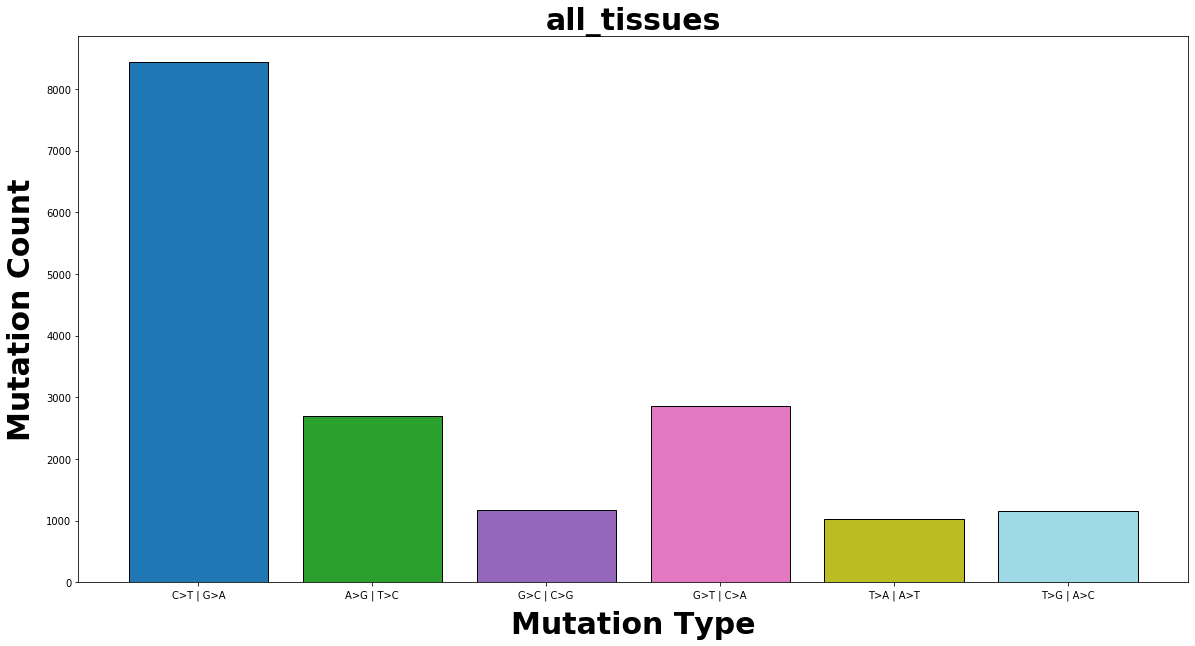

In [7]:
mutation_type_plotter('all_tissues', point_mutation_type_hash)

large_intestine_mutation_plotter Run Time: 0.0 sec
stomach_mutation_plotter Run Time: 0.0 sec
lung_mutation_plotter Run Time: 0.0 sec
biliary_tract_mutation_plotter Run Time: 0.0 sec
oesophagus_mutation_plotter Run Time: 0.0 sec
prostate_mutation_plotter Run Time: 0.0 sec
pancreas_mutation_plotter Run Time: 0.0 sec
small_intestine_mutation_plotter Run Time: 0.0 sec
ovary_mutation_plotter Run Time: 0.0 sec
urinary_tract_mutation_plotter Run Time: 0.0 sec
endometrium_mutation_plotter Run Time: 0.0 sec


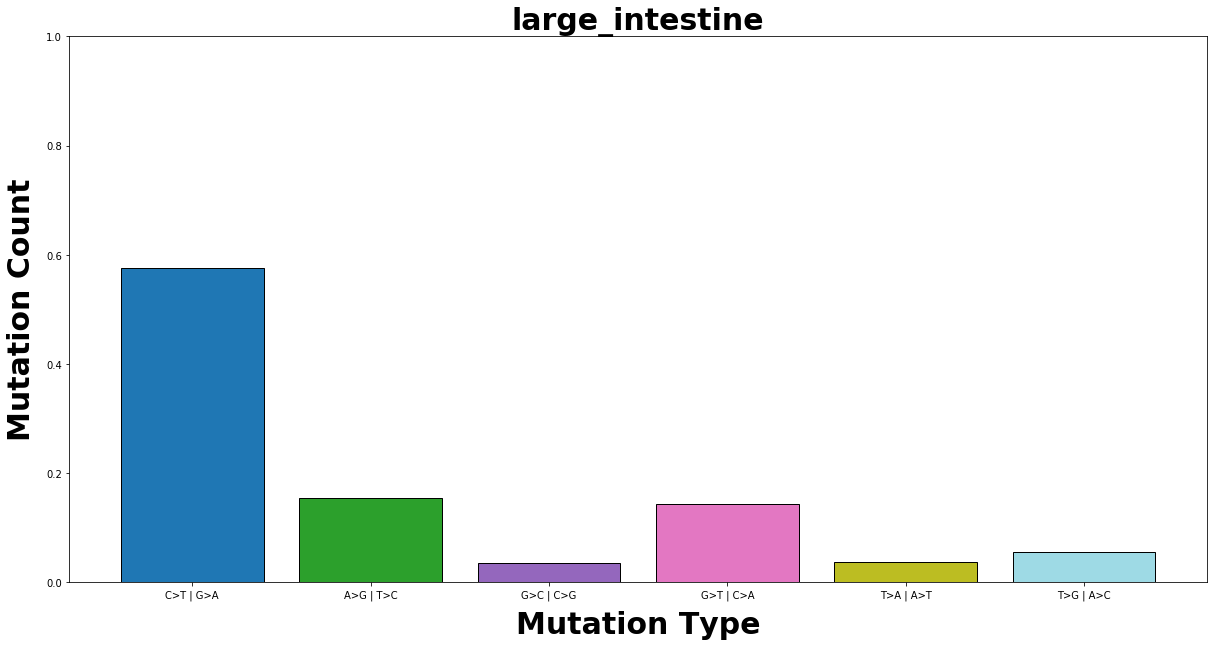

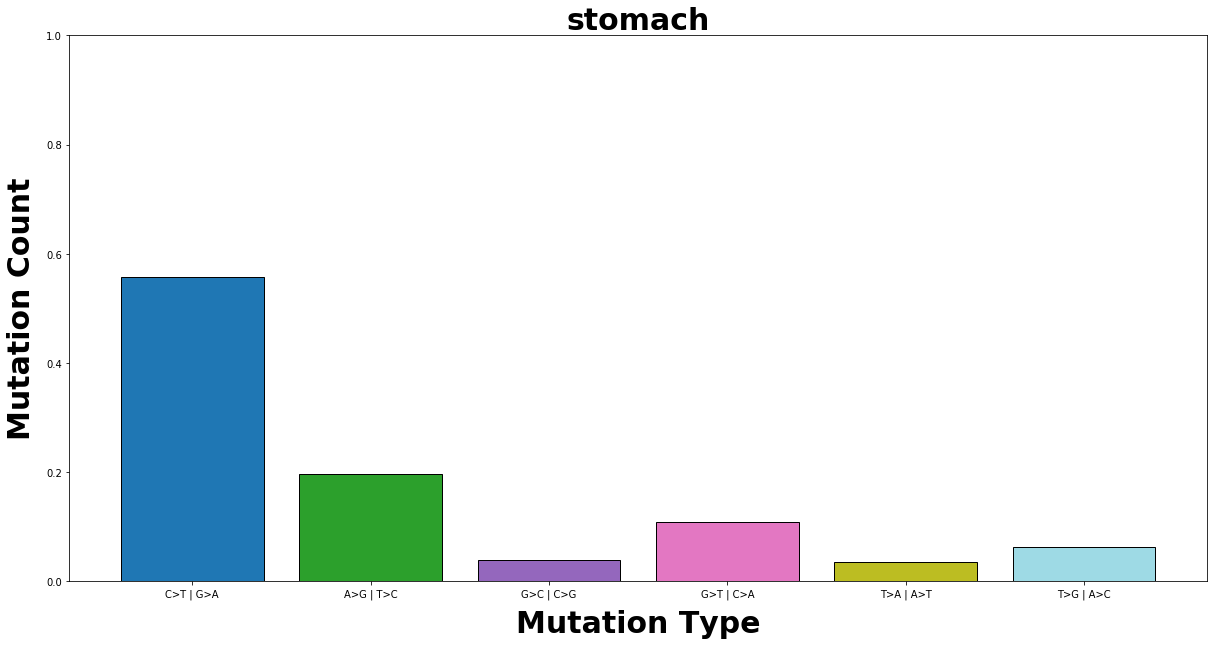

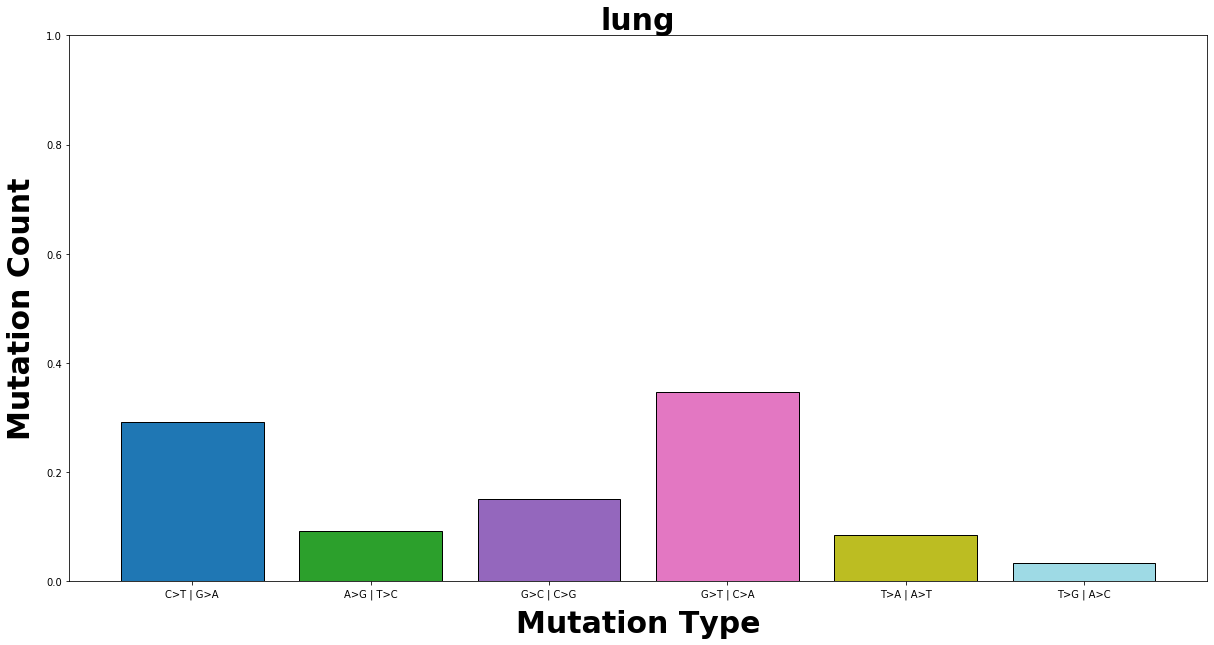

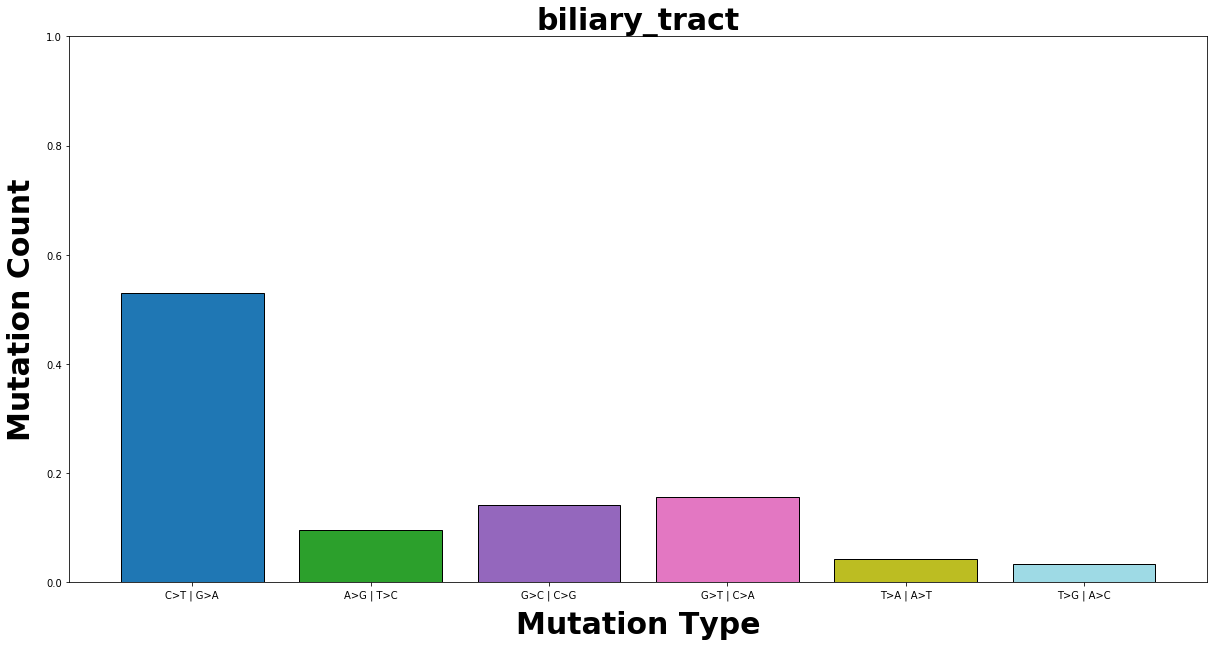

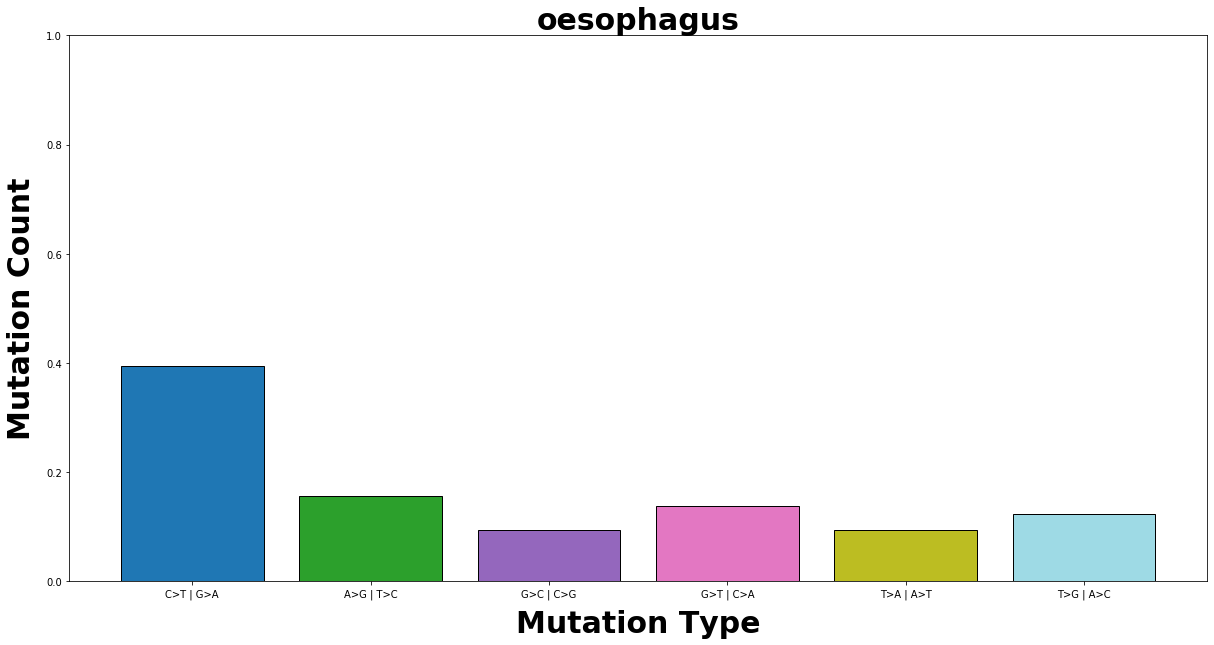

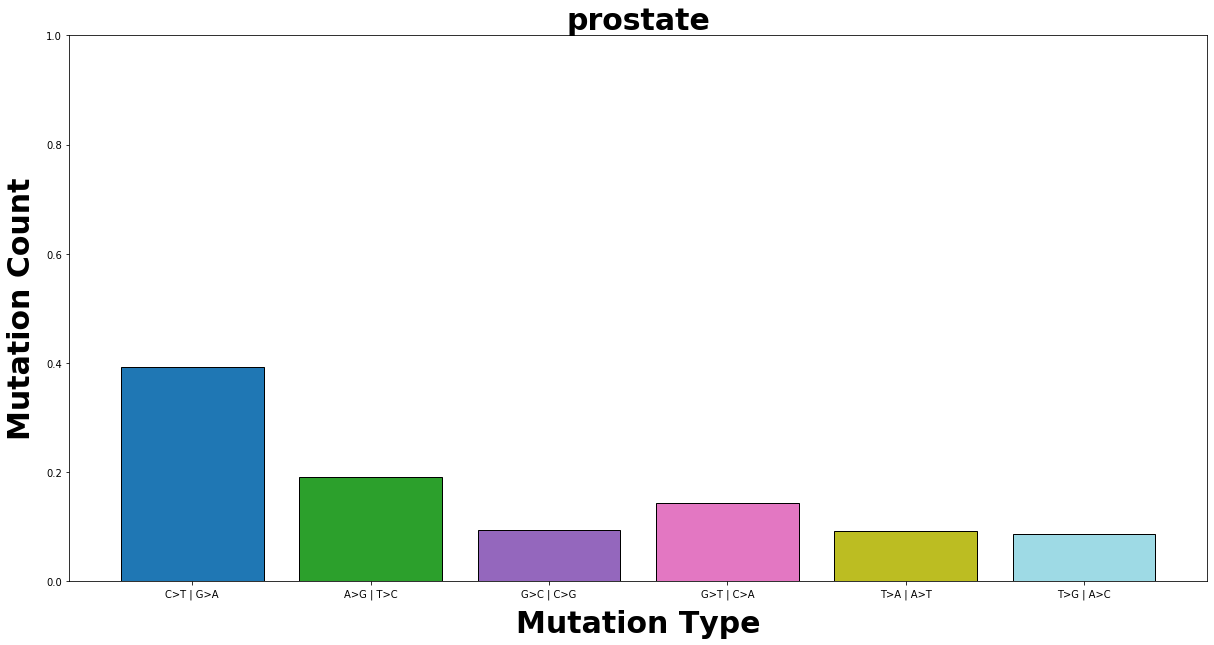

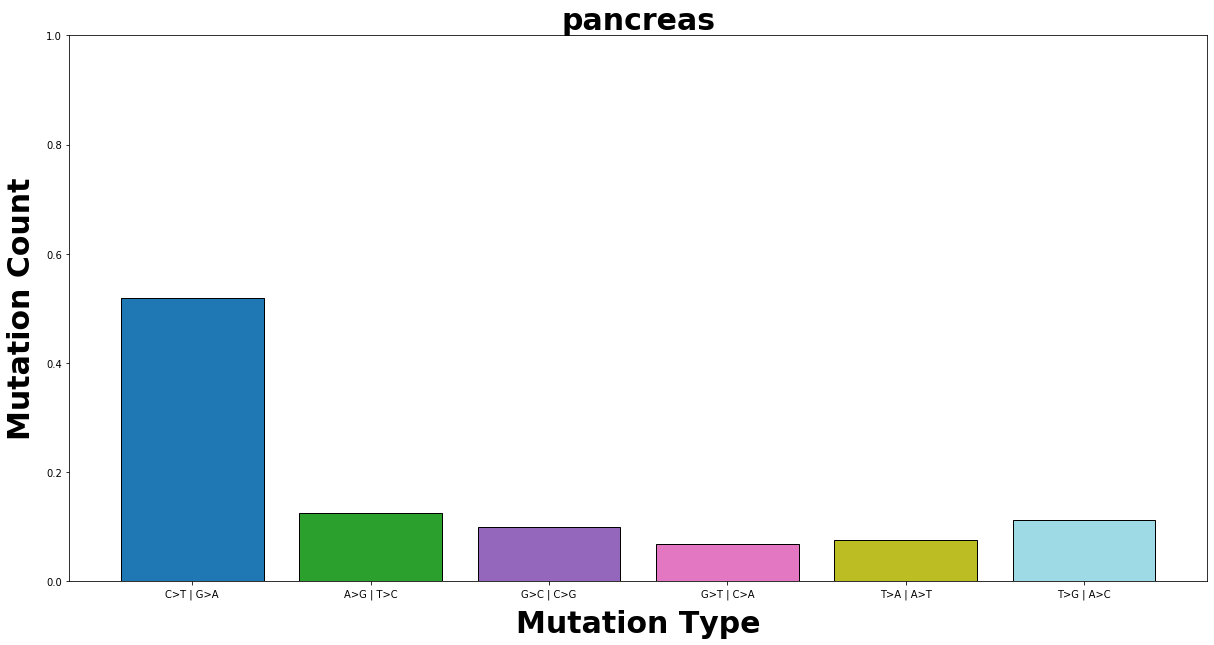

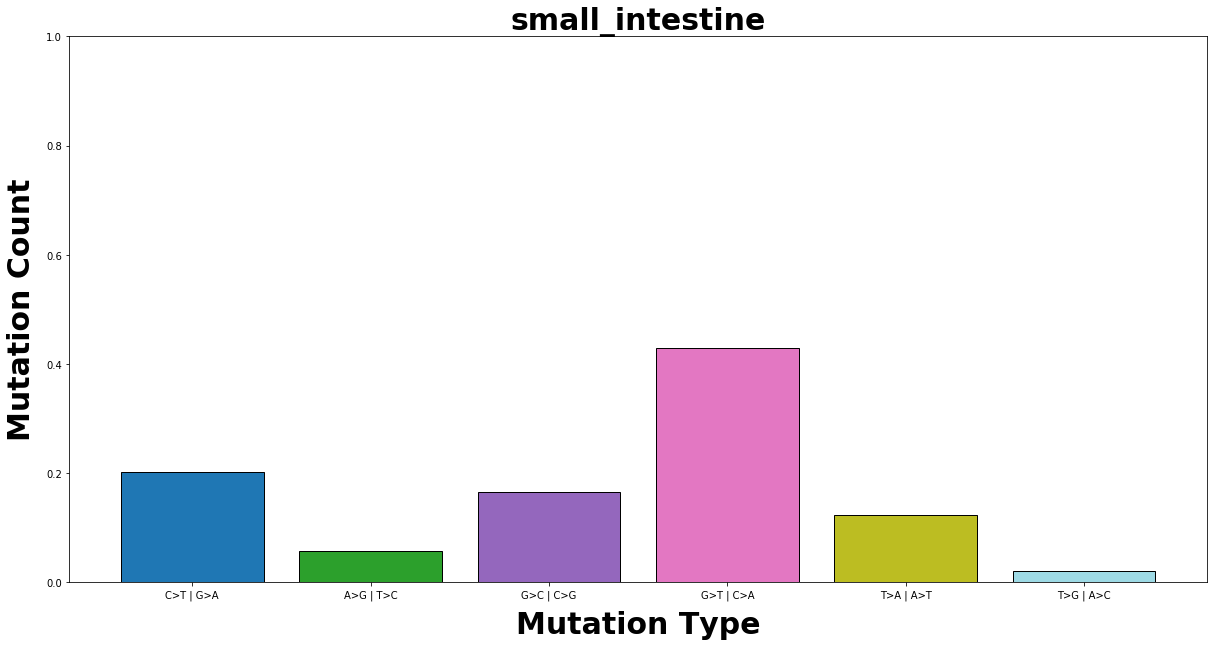

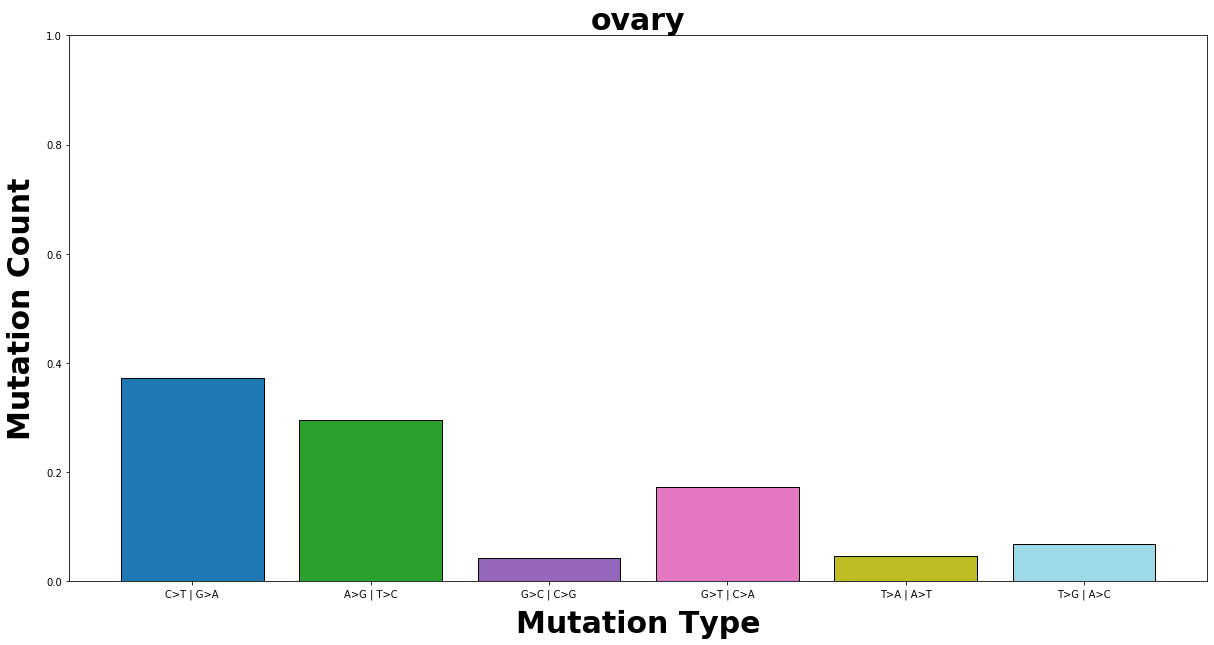

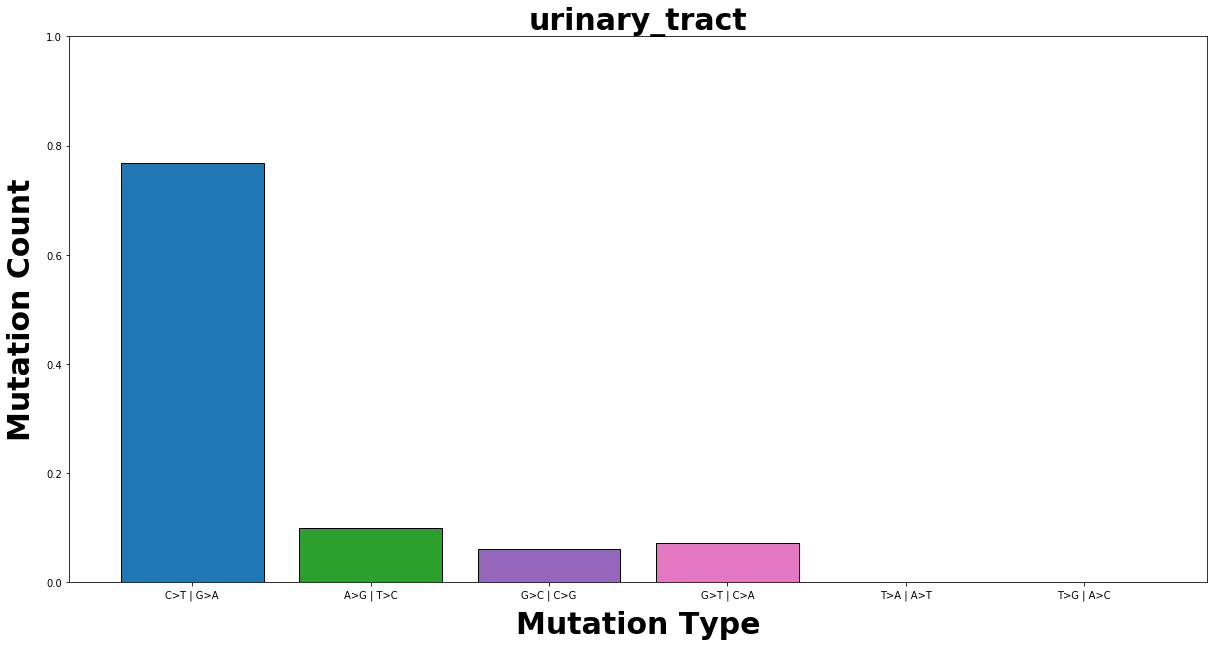

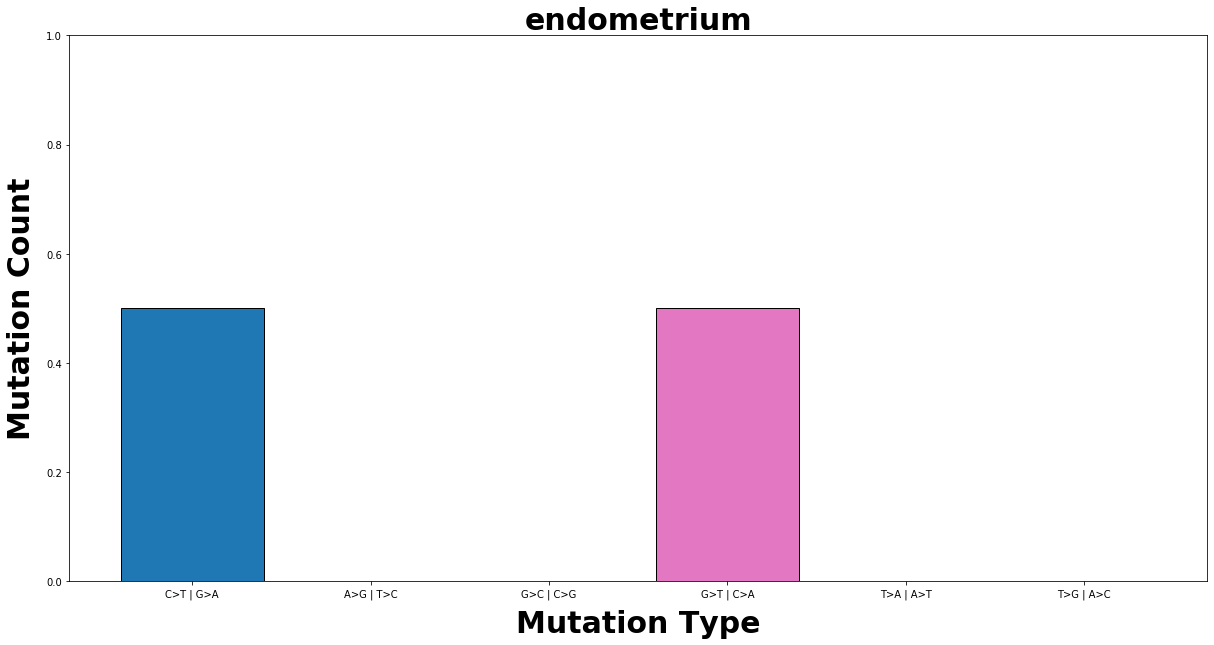

In [8]:
for tissue in point_mutation_type_hash_tissue.keys():
    mutation_type_plotter(tissue, point_mutation_type_hash_tissue[tissue])

In [ ]:
for tissue in point_mutation_type_hash_tissue:
    print(tissue)
    for mutation_type in point_mutation_type_hash_tissue[tissue].keys():
        print('\t', mutation_type + ':', point_mutation_type_hash_tissue[tissue][mutation_type])

large_intestine
	 C>T | G>A: 0.5751563889797847
	 A>G | T>C: 0.1541217096336578
	 G>C | C>G: 0.035835233330626694
	 G>T | C>A: 0.14292430129466194
	 T>A | A>T: 0.03687059782839943
	 T>G | A>C: 0.05509176893286937
stomach
	 C>T | G>A: 0.557567869398082
	 A>G | T>C: 0.1973735100056632
	 G>C | C>G: 0.0392898734463576
	 G>T | C>A: 0.10796920588191697
	 T>A | A>T: 0.034927800625214556
	 T>G | A>C: 0.06287174064276581
lung
	 C>T | G>A: 0.2922833005885091
	 A>G | T>C: 0.09196107887756168
	 G>C | C>G: 0.14999560444446
	 G>T | C>A: 0.3471733054523588
	 T>A | A>T: 0.08466634474325849
	 T>G | A>C: 0.033920365893852
biliary_tract
	 C>T | G>A: 0.5303801056965974
	 A>G | T>C: 0.0966044027416582
	 G>C | C>G: 0.14118719200074994
	 G>T | C>A: 0.15609888107678246
	 T>A | A>T: 0.042049440223734386
	 T>G | A>C: 0.03367997826047767
oesophagus
	 C>T | G>A: 0.39427123733647135
	 A>G | T>C: 0.1557631585209164
	 G>C | C>G: 0.09440248200886582
	 G>T | C>A: 0.13867611533911484
	 T>A | A>T: 0.09429607077890427
	 

# Tyler

# Identification of Driver Mutations
## Method 1: Elucidating the role of background mutational processes (Brown 2019)
Mutagene website and python package
We could easily use this to further characterize the driver mutations in individual top gene candidates. (Even use website)
Of more use would be to remove passenger mutations from our analysis.

1) Run Mutagene Python package.
2) Remove Passengers according to b-score from lists
3) Re-count of mutations across all genes.
4) Could make heatmap or t-sne to compare driver mutations in different tissue types

This would give a more accurate count and identification of oncogenes across cancer types. For example, CSMD1_ENST00000318252 gene, ~90% of mutations are passenger mutations.
Mutagene Website: https://www.ncbi.nlm.nih.gov/research/mutagene/gene#
Mutagene python package: https://www.ncbi.nlm.nih.gov/research/mutagene/package
## Method 2: Evaluating the evaluation of cancer driver genes (Tokheim 2016) 20/20+ software
If we have time, we could also apply this driver mutation analysis to our dataset. Instead of a method based on mutation rate (Mutagene), it uses ratiometric features of mutations by normalizing for the total number of mutations in a gene.
I'm not sure if our data is in the right format or has all the info needed for this analysis. If yes, 1) Run 20/20+ package 2) Could simply rank mutations, but better to look at statistical significance using BH procedure
https://2020plus.readthedocs.io/en/latest/tutorial.html
https://github.com/KarchinLab/2020plus


# Eman

**Driver mutations (Davoli et al.)**
*To do for Rahim: Check how many of our mutations actually tell us the TYPE of mutation. This will determine if the stuff below is feasible*

Pseudocode: 
1. Go through every mutation and check to see if the "Mutation Description" column returns a value other than "Unknown" i.e. that there's something in there we can use for our classifications

2. If we do have it, then find out what different types are listed, keeping in mind that since COSMIC is a combo database it might have multiple names for same type of mutation

3. (We might not have enough data for this bit) Group the mutations by gene and see which genes have >1/3 missense mutations. These are likely oncogenes.

NEW:
- Look through "Age" column for the top X (100?) genes.
- Which genes are mutated most in diff age groups? 0-20, 20-40, 40-70, 70+ years. Maybe plot a graph?

Explanation:

Go through every mutation and count how many gain of function, loss of function, and missense mutations there are

If we group these mutations by *gene*, we could see which genes have maybe > 1/3rd missense mutations. These are likely Oncogenes. Similar critera for TSGs. Could use other parameters mentioned below once we know more.

Fig 1 shows us Mutation signatures across genes (how many GOF, LOF, missense etc). If we could have a similar sense of mutation signatures across different sub-types of adenocarcinoma, we can use this to classify Tumor Suppressor Genes (TSGs) and Oncogenes (OGs). 

TSGs: Higher number of inactivating mutations than background mutation rate
OGs: Higher number of activating missense mutations

The third figure here talks about the Parameters they used to classify OGs and TSGs: LOF/Benign ratio, HiFi/Benign, Splicing/Benign, missense entropy, and so on. All these parameters basically helped them figure out if a gene can be classified as onco or tumor supressor, with a p value assigned to each of these classifications.

Could we do something like this, where we get the nature of each mutation (LOF, GOF, missense for example) and classify them according to similar paramaters to the one these people used? We don't have to go into the same degree of depth of course, but a section for driver mutations will be important for us I think.

The second figure here^ is just placing the OGs and TSGs predicted by the researchers into cellular pathway context. I think having a less cluttered version of this figure would be useful. Once we figure out, say, 20 OGs and TSGs that we think are interesting (not previously studied, or not super generic), I could make a figure like this after doing a lit search about what signaling pathways etc they are a part of. 





In [ ]:
adenocarcinoma_df.head(20)

,Unnamed: 0,Gene name,Accession Number,Gene CDS length,HGNC ID,Sample name,ID_sample,ID_tumour,Primary site,Site subtype 1,Site subtype 2,Site subtype 3,Primary histology,Histology subtype 1,Histology subtype 2,Histology subtype 3,Genome-wide screen,MUTATION_ID,GENOMIC_MUTATION_ID,LEGACY_MUTATION_ID,Mutation CDS,Mutation AA,Mutation Description,Mutation zygosity,LOH,GRCh,Mutation genome position,Mutation strand,SNP,FATHMM prediction,FATHMM score,Mutation somatic status,Pubmed_PMID,ID_STUDY,Sample Type,Tumour origin,Age
0,4,PORCN_ENST00000359882,ENST00000359882.8,1877,17652.0,T213,2658379,2518538,large_intestine,NS,NS,NS,carcinoma,adenocarcinoma,NS,NS,y,94463450,COSV52141488,COSN26989926,c.*50C>T,p.?,Unknown,NaN,NaN,38.0,23:48520526-48520526,+,n,PATHOGENIC,0.84330,Confirmed somatic variant,27149842.0,NaN,NS,NS,61.25
1,8,AP5Z1,ENST00000348624.4,2901,22197.0,HUB-02-B2-087,2607141,2466853,large_intestine,NS,NS,NS,carcinoma,adenocarcinoma,NS,NS,y,93227367,COSV62241638,COSM6038994,c.1919C>T,p.A640V,Substitution - Missense,NaN,NaN,38.0,7:4790572-4790572,+,n,PATHOGENIC,0.80912,Confirmed somatic variant,NaN,670.0,organoid culture,NS,NaN
2,10,OR5A2_ENST00000641361,ENST00000641361.1,6655,15249.0,LP6005409-DNA_B04,2549501,2410956,oesophagus,NS,NS,NS,carcinoma,adenocarcinoma,NS,NS,y,146049795,COSV57391387,COSN23641447,c.-491A>T,p.?,Unknown,NaN,NaN,38.0,11:59426233-59426233,+,n,NEUTRAL,0.09144,Confirmed somatic variant,NaN,535.0,NS,primary,NaN
3,13,THEMIS,ENST00000630369.2,2786,21569.0,LP6005690-DNA_D01,2263414,2130398,oesophagus,NS,NS,NS,carcinoma,adenocarcinoma,NS,NS,y,146773237,COSV64070700,COSN17424375,c.250+1179G>C,p.?,Unknown,NaN,NaN,38.0,6:127853851-127853851,+,n,NEUTRAL,0.03103,Confirmed somatic variant,NaN,535.0,NS,primary,NaN
4,15,THEMIS,ENST00000630369.2,2786,21569.0,587376,1766805,1671125,large_intestine,colon,NS,NS,carcinoma,adenocarcinoma,NS,NS,y,146779744,COSV64072647,COSM1229161,c.19G>T,p.E7*,Substitution - Nonsense,NaN,NaN,38.0,6:127900914-127900914,+,n,NaN,0.64902,Variant of unknown origin,22895193.0,NaN,surgery fresh/frozen,primary,NaN
5,17,THEMIS,ENST00000630369.2,2786,21569.0,0119_CRUK_PC_0119_T1_DNA,2457589,2320426,prostate,NS,NS,NS,carcinoma,adenocarcinoma,NS,NS,y,146784309,COSV64074793,COSN19519824,c.1875+5042C>T,p.?,Unknown,NaN,NaN,38.0,6:127802174-127802174,+,n,NEUTRAL,0.00456,Confirmed somatic variant,NaN,538.0,NS,primary,57.00
6,19,THEMIS,ENST00000630369.2,2786,21569.0,LP6005409-DNA_E02,2263377,2130361,oesophagus,NS,NS,NS,carcinoma,adenocarcinoma,NS,NS,y,146781728,COSV64073699,COSN15104754,c.92-16601C>A,p.?,Unknown,NaN,NaN,38.0,6:127871789-127871789,+,n,NEUTRAL,0.00738,Confirmed somatic variant,NaN,535.0,NS,primary,NaN
7,22,IRF6_ENST00000542854,ENST00000542854.5,4256,6121.0,CPCG0123-F1,2340851,2205834,prostate,NS,NS,NS,carcinoma,adenocarcinoma,NS,NS,y,131394378,COSV65418639,COSN27928355,c.-111-82T>G,p.?,Unknown,NaN,NaN,38.0,1:209796634-209796634,+,n,NEUTRAL,0.00474,Confirmed somatic variant,NaN,537.0,NS,primary,NaN
8,27,NLRP12_ENST00000391772,ENST00000391772.1,3205,22938.0,TCGA-BR-A4QL-01,2197931,2066209,stomach,NS,NS,NS,carcinoma,adenocarcinoma,NS,NS,y,99777853,COSV60743594,COSM4081077,c.2592-4129G>A,p.?,Unknown,NaN,NaN,38.0,19:53798265-53798265,+,n,NEUTRAL,0.00145,Confirmed somatic variant,NaN,541.0,NS,NS,75.00
9,29,NLRP12_ENST00000391772,ENST00000391772.1,3205,22938.0,T3064,2296168,2161771,large_intestine,colon,transverse,NS,carcinoma,adenocarcinoma,NS,NS,y,99783014,COSV60748411,COSM4707248,c.1952C>T,p.S651L,Substitution - Missense,NaN,NaN,38.0,19:53809707-53809707,+,n,NEUTRAL,0.09601,Confirmed somatic variant,25344691.0,NaN,NS,NS,75.50


mutation_description Run Time: 2.5 sec


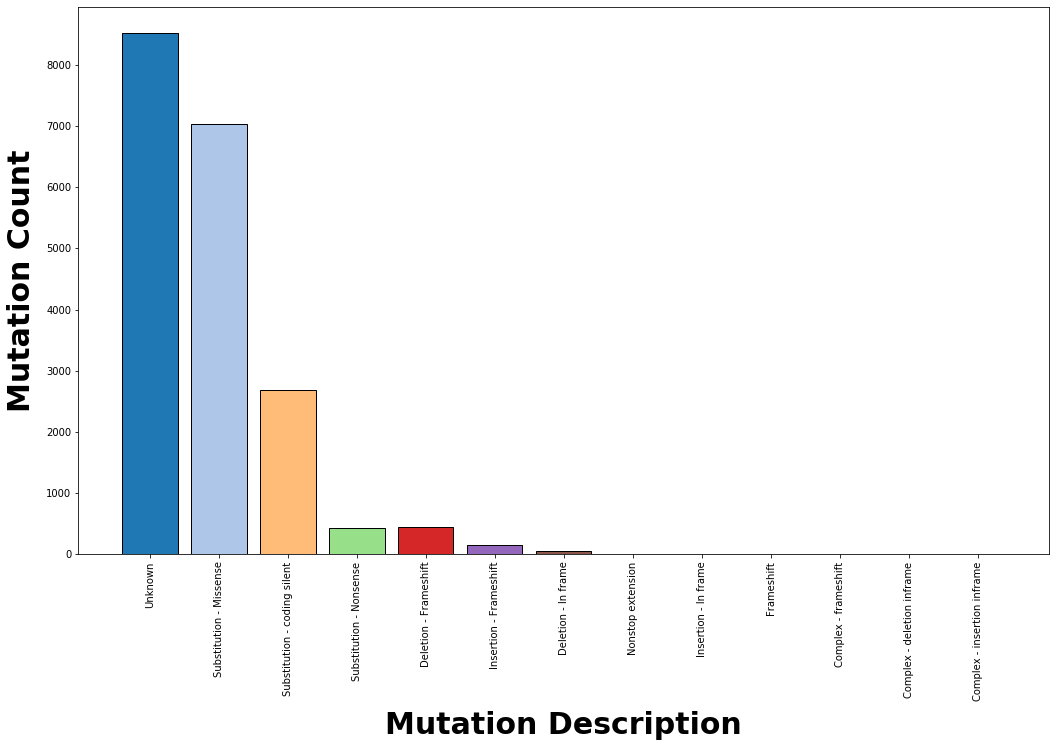

In [ ]:
def mutation_description():
    mutation_description_hash = {}
    for gi, gene in enumerate(adeno_hash.keys()):
        for mi, mutation in enumerate(adeno_hash[gene]['Mutation Description']):
            if mutation in mutation_description_hash.keys():
                mutation_description_hash[mutation] += 1/(len(adeno_hash[gene]['Mutation Description']))
            else:
                mutation_description_hash[mutation] = 1/(len(adeno_hash[gene]['Mutation Description']))
    #sorted(mutation_description_hash, key=point_mutation_type_hash.get, reverse=True)
    return(mutation_description_hash)

def mutation_description_plotter(mutation_type_hash):
    # mutation_description_plotter
    start_time = time.time()
    f, ax = plt.subplots(1)
    colors = mpl.cm.tab20(np.linspace(0,1,len(mutation_type_hash.keys())))
    ax.bar(mutation_type_hash.keys(), mutation_type_hash.values(), color=colors, edgecolor='black')
    ax.set_xlabel('Mutation Description', fontweight='bold', labelpad=10, fontsize=30)
    ax.set_ylabel('Mutation Count', fontweight='bold', labelpad=10, fontsize=30)
    plt.tight_layout(pad=0.05, w_pad=4, h_pad=1.0)
    plt.xticks(rotation=90)
    f.set_size_inches(18.5, 10.5, forward=True)
    plt.savefig(path+'/Images/mutation_description.png', dpi=300)
    end_time = time.time()
    print('mutation_description Run Time:', str(end_time-start_time)[:3], 'sec')

mutation_description_hash = mutation_description()
mutation_description_plotter(mutation_description_hash)

In [ ]:
def missense_counter():
    '''
    missense_counter counts the ratio of missense mutations
    to the total number of non-unknown mutations captured for
    each gene
    '''
    start_time = time.time()
    missense_hash = defaultdict(float)
    all_non_unknown_hash = defaultdict(int)
    for gi, gene in enumerate(adeno_hash.keys()):
        mutation_desc_list = adeno_hash[gene]['Mutation Description']
        try:
            missense_hash[gene] = mutation_desc_list.count('Substitution - Missense')/(len(mutation_desc_list) - mutation_desc_list.count('Unknown'))
        except:
            # All mutations for specified gene are unknown
            missense_hash[gene] = 0
        all_non_unknown_hash[gene] = len(mutation_desc_list) - mutation_desc_list.count('Unknown')
    end_time = time.time()
    print('missense_counter Run Time:', str(end_time-start_time), 'sec')
    print('Writing data to missense_count.csv in:', path+'/Datasets/')
    # Write .csv with all missense rates and total mutation counts
    with open(path+'/Datasets/missense_count.csv', 'w') as missense_file:
        missense_writer = csv.writer(missense_file, delimiter=',')
        for gene in missense_hash.keys():
            missense_writer.writerow([gene, missense_hash[gene], all_non_unknown_hash[gene]])
    return missense_hash, all_non_unknown_hash

missense_hash, all_non_unknown_hash = missense_counter()

missense_counter Run Time: 0.5341153144836426 sec
Writing data to missense_count.csv in: /content/gdrive/My Drive/Columbia/Year II/Fall II/Deep Sequencing/Final Project/Datasets/


missense_plotter Run Time: 3.261855363845825 sec


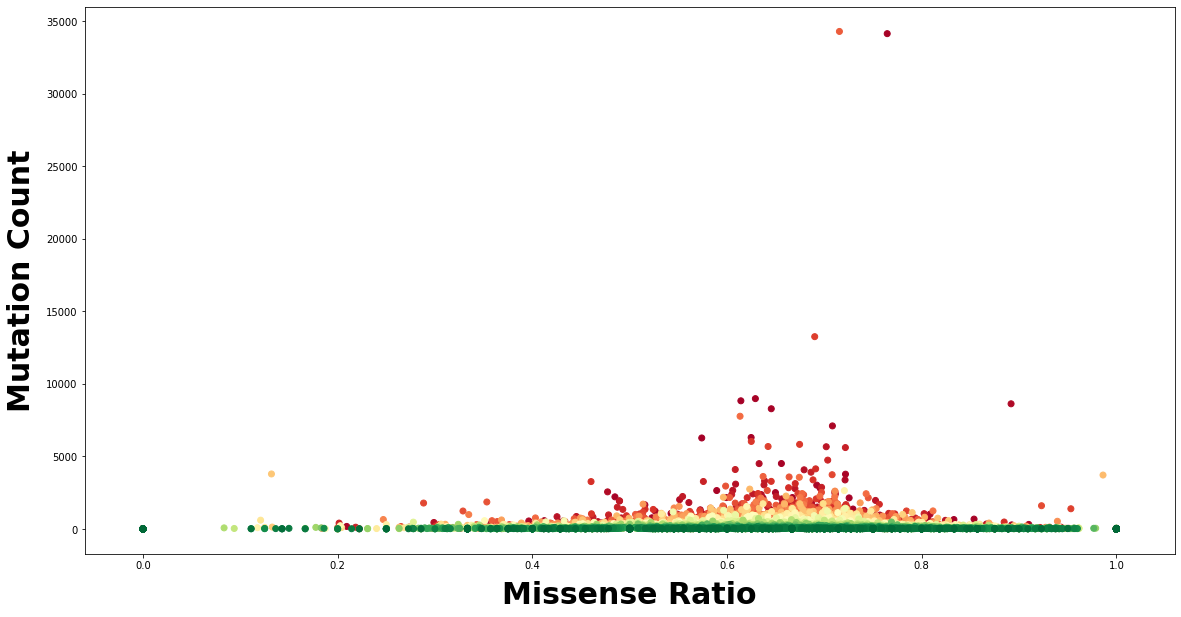

In [ ]:
def missense_plotter(missense_hash, all_non_unknown_hash):
    '''
    missense_plotter plots the distribution of 
    mutation count vs. missense ratio to find the
    genes that are potentially oncogenes, as previous
    papers report that genes with high missense ratio
    counts are likely to be oncogenes.
    '''
    # gene length x mutation count plotter
    start_time = time.time()
    f, ax = plt.subplots(1)
    gene_list = list(missense_hash.keys())
    missense_count = list(missense_hash.values())
    all_non_unknown_count = list(all_non_unknown_hash.values())
    colors = mpl.cm.RdYlGn(np.linspace(0,1,len(gene_list)))
    ax.set_xlabel('Missense Ratio', fontweight='bold', labelpad=10, fontsize=30)
    ax.set_ylabel('Mutation Count', fontweight='bold', labelpad=10, fontsize=30)
    plt.scatter(missense_count, all_non_unknown_count, color=colors)
    plt.tight_layout(pad=0.05, w_pad=4, h_pad=1.0)
    f.set_size_inches(18.5, 10.5, forward=True)
    plt.savefig(path+'/Images/missense_ratio.png', dpi=300)
    end_time = time.time()
    print('missense_plotter Run Time:', str(end_time-start_time), 'sec')

missense_plotter(missense_hash, all_non_unknown_hash)

In [ ]:
def age_counter():
    '''
    age_counter counts the age distribution for patients
    with mutations captured in the Cosmic dataset to see
    if genes in age-dependent populations are differentially
    modulated.
    '''
    start_time = time.time()
    age_hash = defaultdict(float)
    mutation_count = defaultdict(int)
    for gi, gene in enumerate(adeno_hash.keys()):
        age_hash[gene] = adeno_hash[gene]['Age']
        mutation_count[gene] = adeno_hash[gene]['mutation_count']
    end_time = time.time()
    print('age_counter Run Time:', str(end_time-start_time), 'sec')
    print('Writing data to age_count.csv in:', path+'/Datasets/')
    with open(path +'/Datasets/age_count.csv', 'w') as age_file:
        age_writer = csv.writer(age_file, delimiter=',')
        for gene in age_hash.keys():
            age_writer.writerow([gene, age_hash[gene], np.nanmean(age_hash[gene]), mutation_count[gene]])

age_counter()

age_counter Run Time: 0.022298097610473633 sec
Writing data to age_count.csv in: /content/gdrive/My Drive/Columbia/Year II/Fall II/Deep Sequencing/Final Project/Datasets/


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
